## Hybrid Movie Recommender System with Temporal Contextual Filtering




### **Import the required Python libraries**

In [2982]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import warnings
import base64
import io
from matplotlib.pyplot import imread
import codecs
from IPython.display import HTML
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

### **Import the dataset**

In [2983]:
movies_tmdb = pd.read_csv('/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('/tmdb-movie-metadata/tmdb_5000_credits.csv')
movies_movielens=pd.read_csv('/movie-lens-100k/movies.csv')
ratings_movielens=pd.read_csv('/input/movie-lens-100k/ratings.csv')

## **Data Exploration & Cleaning**

In [2984]:
movies_movielens.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2985]:
movies_movielens = movies_movielens.rename(columns={'genres': 'genre'})

In [2986]:
ratings_movielens.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


**Converting JSON into strings**

In [2987]:
# changing the genres column from json to string
movies_tmdb['genres'] = movies_tmdb['genres'].apply(json.loads)
for index,i in zip(movies_tmdb.index,movies_tmdb['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies_tmdb.loc[index,'genres'] = str(list1)

# changing the keywords column from json to string
movies_tmdb['keywords'] = movies_tmdb['keywords'].apply(json.loads)
for index,i in zip(movies_tmdb.index,movies_tmdb['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies_tmdb.loc[index,'keywords'] = str(list1)
    
# changing the production_companies column from json to string
movies_tmdb['production_companies'] = movies_tmdb['production_companies'].apply(json.loads)
for index,i in zip(movies_tmdb.index,movies_tmdb['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies_tmdb.loc[index,'production_companies'] = str(list1)

# changing the cast column from json to string
credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)

# changing the crew column from json to string    
credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

### **Merging the two csv files**

In [2988]:
movies_tmdb = movies_tmdb.merge(credits,left_on='id',right_on='movie_id',how='left')
movies_tmdb = movies_tmdb[['id','original_title','genres','cast','vote_average','director','keywords']]

In [2989]:
duplicate_values = movies_tmdb.duplicated(subset='original_title', keep=False)

# Filter the DataFrame to keep only rows with unique values in the specified column
movies_tmdb = movies_tmdb[~duplicate_values]


In [2990]:
duplicate_values = movies_movielens.duplicated(subset='title', keep=False)

# Filter the DataFrame to keep only rows with unique values in the specified column
movies_movielens = movies_movielens[~duplicate_values]


In [2991]:
movies_tmdb['original_title'] = movies_tmdb['original_title'].astype(str).str.lower().str.replace(' ', '')
movies_movielens['title_key'] = movies_movielens['title'].astype(str).str.lower().str.replace(' ', '')

In [2992]:
movies_movielens['title_key']=movies_movielens.title_key.str.replace('(\(\d\d\d\d\))','',regex=True)
movies_movielens['title_key']=movies_movielens['title_key'].apply(lambda x:x.strip())
movies_movielens['title_with_release_year']=movies_movielens['title']
movies_movielens['title']=movies_movielens.title.str.replace('(\(\d\d\d\d\))','',regex=True)
movies_movielens['title']=movies_movielens['title'].apply(lambda x:x.strip())

In [2993]:
movies_movielens.head()

,movieId,title,genre,title_key,title_with_release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,toystory,Toy Story (1995)
1,2,Jumanji,Adventure|Children|Fantasy,jumanji,Jumanji (1995)
2,3,Grumpier Old Men,Comedy|Romance,grumpieroldmen,Grumpier Old Men (1995)
3,4,Waiting to Exhale,Comedy|Drama|Romance,waitingtoexhale,Waiting to Exhale (1995)
4,5,Father of the Bride Part II,Comedy,fatherofthebridepartii,Father of the Bride Part II (1995)


In [2994]:
common_rows = movies_tmdb[movies_tmdb['original_title'].isin(movies_movielens['title_key'].tolist())]

# Get the number of common rows
num_common_rows = len(common_rows)
common_rows.shape

(2554, 7)

In [2995]:
movies = pd.merge(movies_tmdb, movies_movielens, how='inner', left_on='original_title', right_on='title_key')

In [2996]:
movies = movies.drop(['title'], axis=1)

In [2997]:
movies = movies.drop(['genre'], axis=1)

In [2998]:
duplicate_values = movies.duplicated(subset='original_title', keep=False)

# Filter the DataFrame to keep only rows with unique values in the specified column
movies = movies[~duplicate_values]

In [2999]:
rating=ratings_movielens[ratings_movielens['movieId'].isin(movies['movieId'].tolist())]
rating.shape

(46710, 4)

## **Working with the Genres column**

In [3000]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

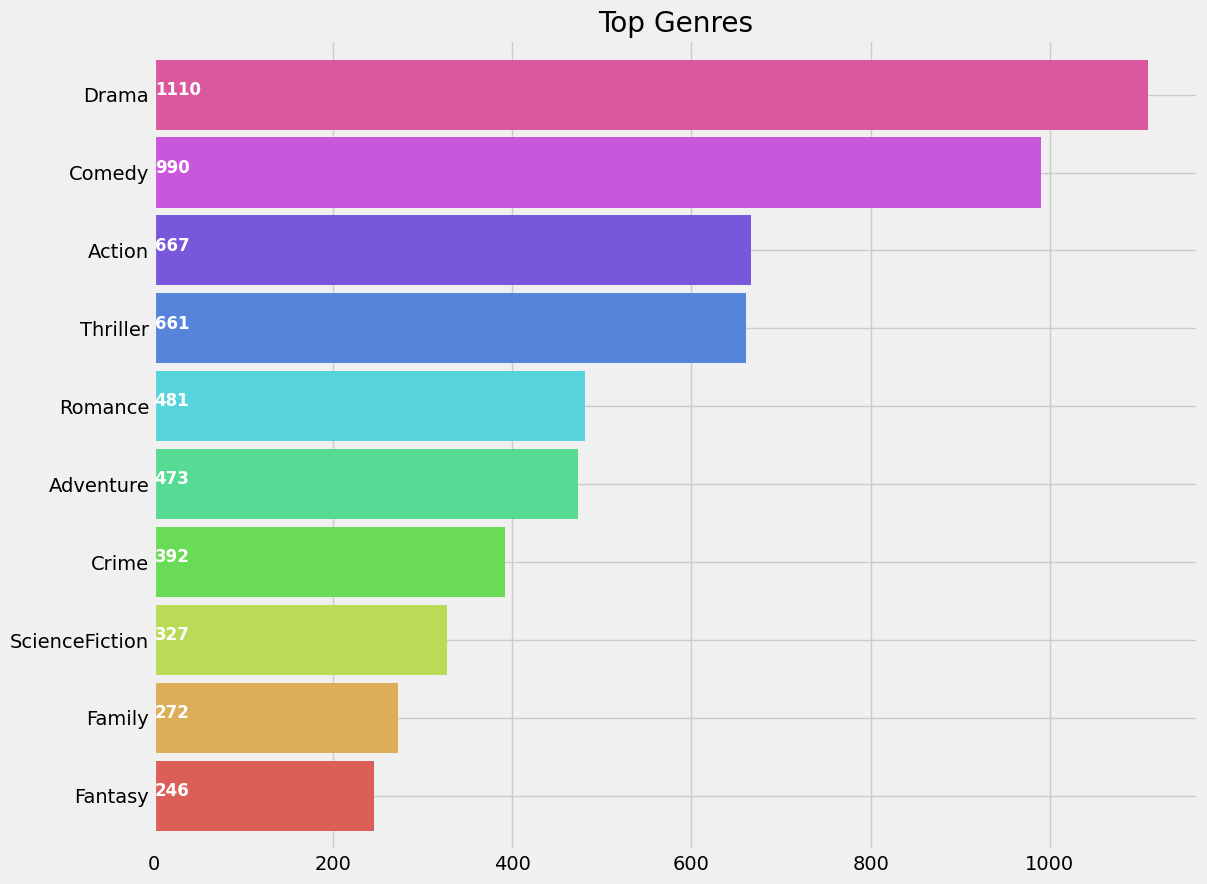

In [3001]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

Drama appears to be the most popular genre followed by Comedy.

In [3002]:
for i,j in zip(movies['genres'],movies.index):
    list2=[]
    list2=i
    list2.sort()
    movies.loc[j,'genres']=str(list2)
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

Generating a list 'genreList' with all possible unique genres mentioned in the dataset.



In [3003]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres

['Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'Crime',
 'Animation',
 'Family',
 'Thriller',
 'Comedy',
 'Drama']

**One Hot Encoding for multiple labels**

In [3004]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [3005]:
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

## **Working with the Cast Column**
 

In [3006]:
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

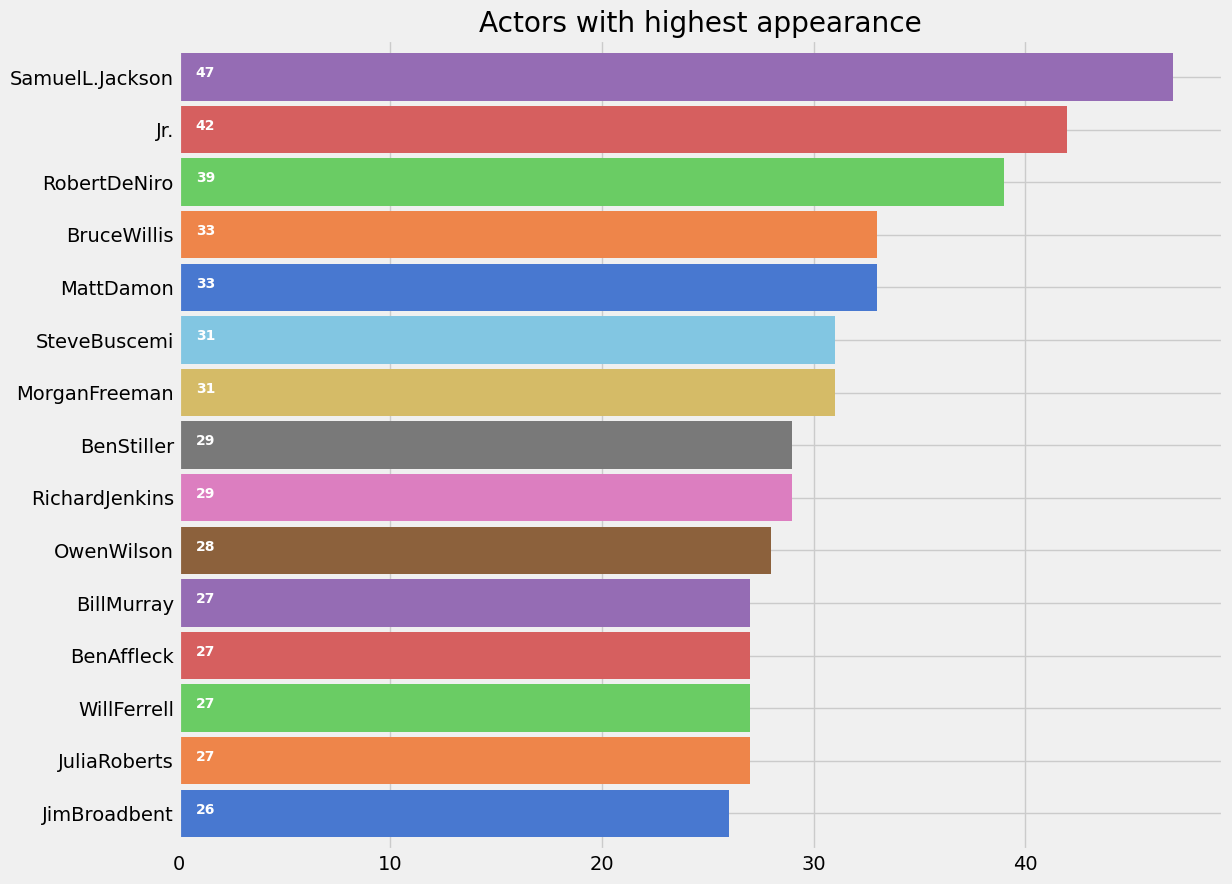

In [3007]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

In [3008]:
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:4]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

In [3009]:
castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

In [3010]:
def binary(cast_list):
    binaryList = []
    
    for genre in castList:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [3011]:
movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))
movies['cast_bin'].head()

0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...
2    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
4    [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: cast_bin, dtype: object

## **Working with Director column**

In [3012]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)

In [3013]:
movies.head()

,id,original_title,genres,cast,vote_average,director,keywords,movieId,title_key,title_with_release_year,genres_bin,cast_bin
0,19995,avatar,"[Action, Adventure, Fantasy, ScienceFiction]","SamWorthington,SigourneyWeaver,StephenLang,Zoe...",7.2,James Cameron,"['culture clash', 'future', 'space war', 'spac...",72998,avatar,Avatar (2009),"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,285,piratesofthecaribbean:atworld'send,"[Action, Adventure, Fantasy]","JohnnyDepp,KeiraKnightley,OrlandoBloom,Stellan...",6.9,Gore Verbinski,"['ocean', 'drug abuse', 'exotic island', 'east...",53125,piratesofthecaribbean:atworld'send,Pirates of the Caribbean: At World's End (2007),"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
2,206647,spectre,"[Action, Adventure, Crime]","ChristophWaltz,DanielCraig,LéaSeydoux,RalphFie...",6.3,Sam Mendes,"['spy', 'based on novel', 'secret agent', 'seq...",136020,spectre,Spectre (2015),"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,49529,johncarter,"[Action, Adventure, ScienceFiction]","LynnCollins,SamanthaMorton,TaylorKitsch,Willem...",6.1,Andrew Stanton,"['based on novel', 'mars', 'medallion', 'space...",93363,johncarter,John Carter (2012),"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."
4,559,spider-man3,"[Action, Adventure, Fantasy]","JamesFranco,KirstenDunst,ThomasHadenChurch,Tob...",5.9,Sam Raimi,"['dual identity', 'amnesia', 'sandstorm', ""lov...",52722,spider-man3,Spider-Man 3 (2007),"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


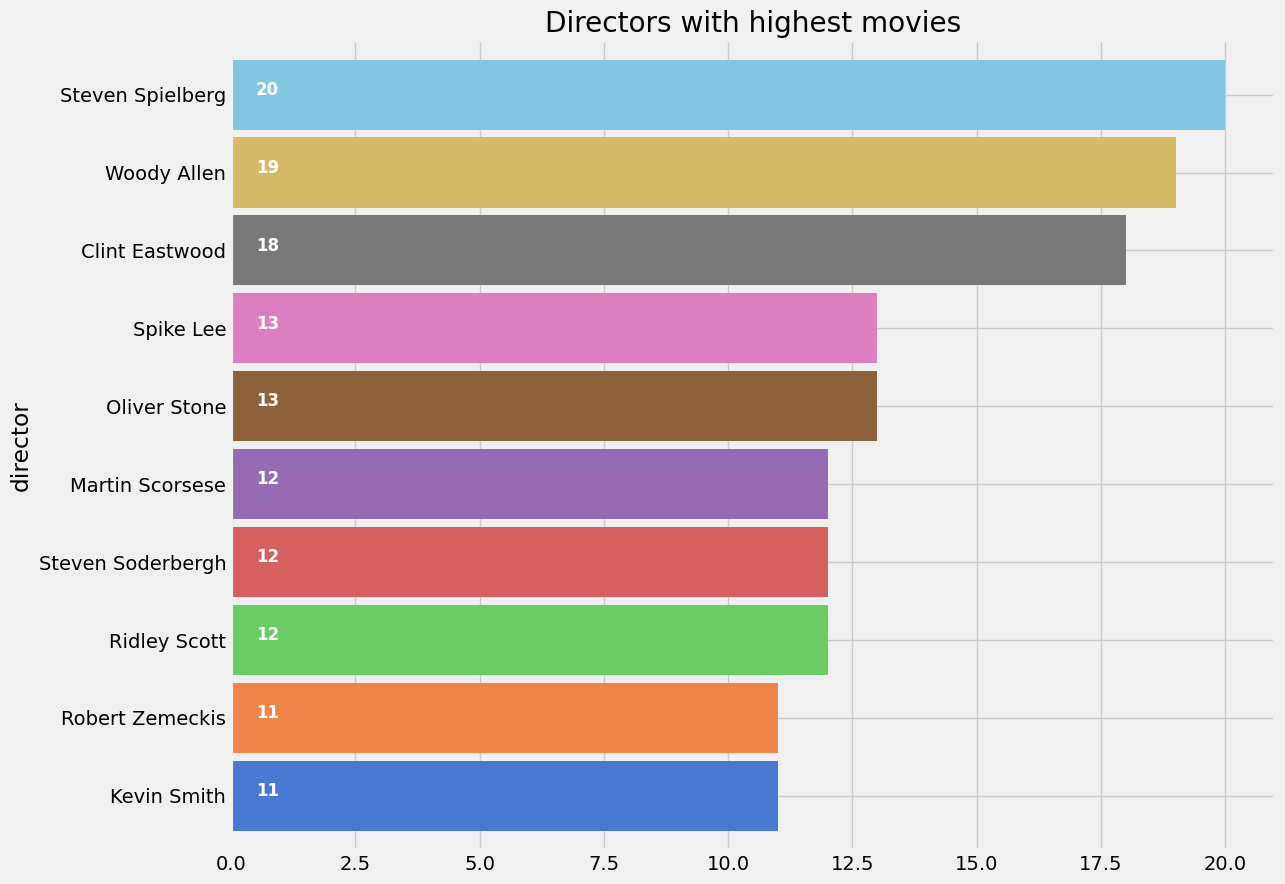

In [3014]:
plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

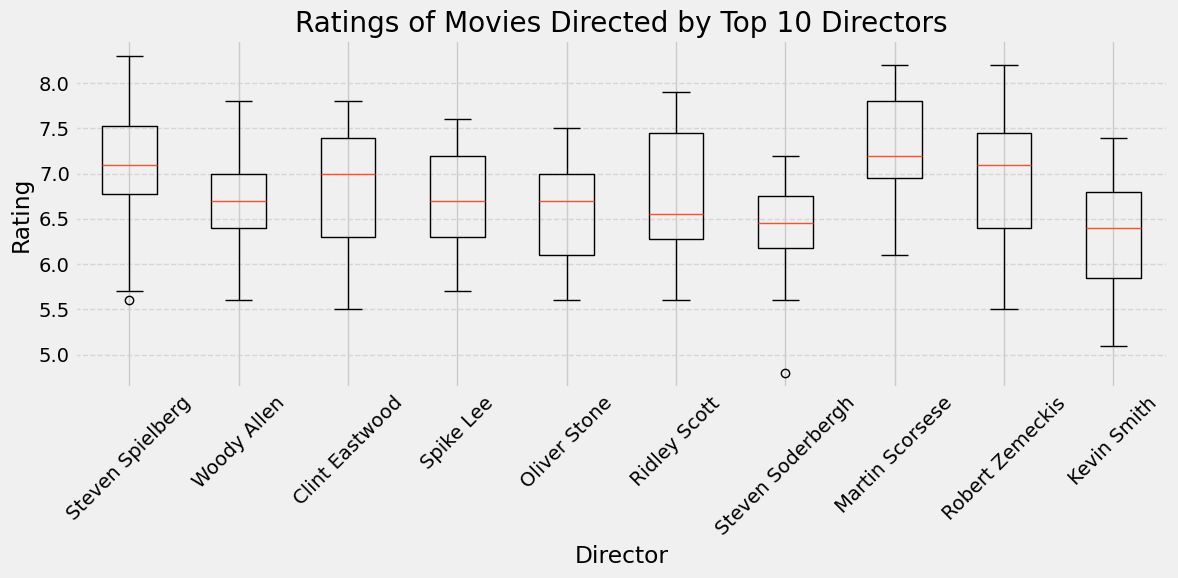

In [3015]:
director_movie_counts = movies['director'].value_counts()

# Select the top 10 directors based on movie count
top_10_directors = director_movie_counts.head(10).index

# Filter the data to include only movies directed by the top 10 directors
filtered_df = movies[movies['director'].isin(top_10_directors)]

# Create a boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([filtered_df[filtered_df['director'] == director]['vote_average'] for director in top_10_directors], labels=top_10_directors)
plt.title('Ratings of Movies Directed by Top 10 Directors')
plt.xlabel('Director')
plt.ylabel('Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [3016]:
directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

In [3017]:
def binary(director_list):
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [3018]:
movies['director_bin'] = movies['director'].apply(lambda x: binary(x))

In [3019]:
MLmovie=pd.read_csv('/kaggle/input/movie-lens-100k/movies.csv')
movie3 = pd.merge(MLmovie[['movieId', 'title']], movies, on='movieId')

In [3020]:
movies=movie3
movies.head()

,movieId,title,id,original_title,genres,cast,vote_average,director,keywords,title_key,title_with_release_year,genres_bin,cast_bin,director_bin
0,1,Toy Story (1995),862,toystory,"[Animation, Comedy, Family]","DonRickles,JimVarney,TimAllen,TomHanks",7.7,John Lasseter,"['jealousy', 'toy', 'boy', 'friendship', 'frie...",toystory,Toy Story (1995),"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,10,GoldenEye (1995),710,goldeneye,"[Action, Adventure, Thriller]","FamkeJanssen,IzabellaScorupco,PierceBrosnan,Se...",6.6,Martin Campbell,"['cuba', 'falsely accused', 'secret identity',...",goldeneye,GoldenEye (1995),"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,14,Nixon (1995),10858,nixon,"[Drama, History]","AnthonyHopkins,EdHarris,JoanAllen,PowersBoothe",7.1,Oliver Stone,"['usa president', 'presidential election', 'wa...",nixon,Nixon (1995),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,Cutthroat Island (1995),1408,cutthroatisland,"[Action, Adventure]","FrankLangella,GeenaDavis,MatthewModine,MauryCh...",5.7,Renny Harlin,"['exotic island', 'treasure', 'map', 'ship', '...",cutthroatisland,Cutthroat Island (1995),"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,16,Casino (1995),524,casino,"[Crime, Drama]","JamesWoods,JoePesci,RobertDeNiro,SharonStone",7.8,Martin Scorsese,"['poker', 'drug abuse', '1970s', 'overdose', '...",casino,Casino (1995),"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## **Working with the Keywords column**

In [3021]:
movies.drop(columns=['original_title'],inplace=True)
movies.rename(columns={"title_x": "original_title"}, inplace=True)

In [3022]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

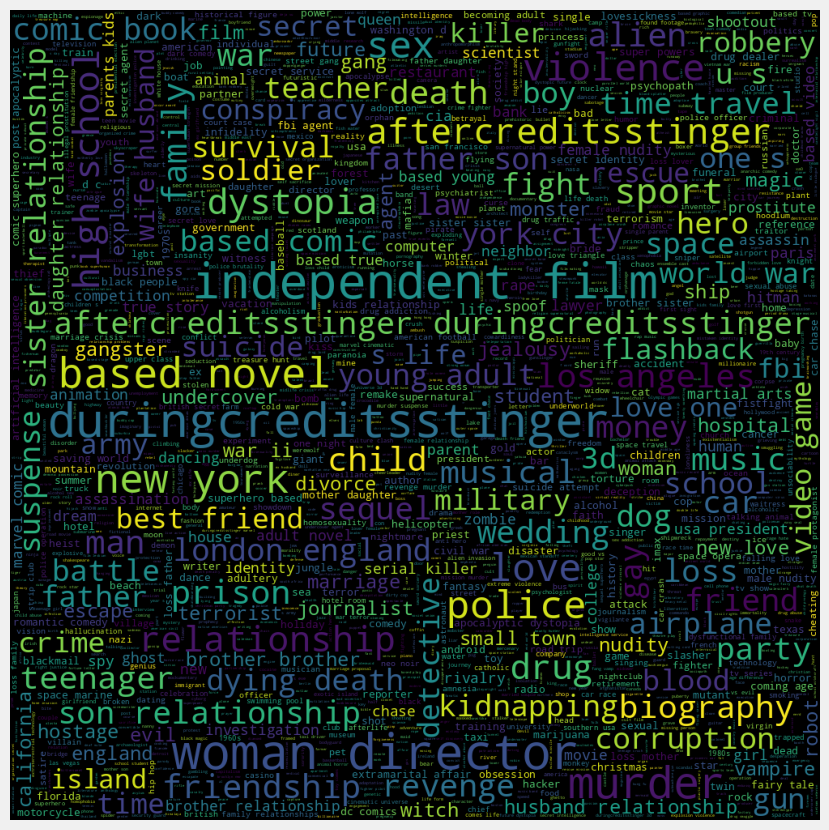

In [3023]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Above is a wordcloud showing the major keywords or tags used for describing the movies.


In [3024]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')

In [3025]:
words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

In [3026]:
def binary(words):
    binaryList = []
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [3027]:
movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))
movies = movies[(movies['vote_average']!=0)] #removing the movies with 0 score and without drector names 
movies = movies[movies['director']!='']

## Similarity between movies

We will we using Cosine Similarity for finding the similarity between 2 movies. 

In [3028]:
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance

In [3029]:
Similarity(3,160) #checking similarity between any 2 random movies

1.7911109405107013

We see that the distance is about 2.068, which is high. The more the distance, the less similar the movies are. Let's see what these random movies actually were.

In [3030]:
print(movies.iloc[3])
print(movies.iloc[160])

movieId                                                                   15
title                                                Cutthroat Island (1995)
id                                                                      1408
genres                                                   [Action, Adventure]
cast                       FrankLangella,GeenaDavis,MatthewModine,MauryCh...
vote_average                                                             5.7
director                                                        Renny Harlin
keywords                   [exoticisland, map, pirate, scalp, ship, treas...
title_key                                                    cutthroatisland
title_with_release_year                              Cutthroat Island (1995)
genres_bin                 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
cast_bin                   [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
director_bin               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [3031]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies.rename(columns={"title": "original_title"}, inplace=True)
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
#movies.shape

## **Score Predictor**

In [3032]:
import operator
total_neighbors = []
def KNN_predict_score(name):
#     name = input('Enter a movie title: ')
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))

        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    neighbors = getNeighbors(new_movie, K)
    total_neighbors.extend(neighbors)
    total_neighbors.sort(key=operator.itemgetter(1))

Get all the movies for a test userId

In [3033]:
rating.shape

(46710, 4)

In [3034]:
unique_user_ids=rating['userId'].unique()
len(unique_user_ids)

671

In [3035]:
from sklearn.model_selection import train_test_split
train_userIds,test_userIds=train_test_split(unique_user_ids,test_size=0.2, random_state=42)
len(train_userIds)

536

In [3036]:
len(test_userIds)

135

In [3037]:
train_rating = pd.DataFrame(columns=rating.columns)
test_rating = pd.DataFrame(columns=rating.columns)

for userId in train_userIds:
    train_rating=pd.concat([train_rating,rating[rating['userId']==userId]],ignore_index=True)

for userId in test_userIds:
    test_rating=pd.concat([test_rating,rating[rating['userId']==userId]],ignore_index=True)

In [3038]:
inputUserID=input("Enter User ID:")
print(inputUserID)
inputUser = test_rating[test_rating['userId']==int(inputUserID)]
inputUser.shape

Enter User ID: 83


83


(84, 4)

In [3039]:
inputUser.head()

,userId,movieId,rating,timestamp
10332,83,21,1.0,1156206448
10333,83,39,4.0,1156207541
10334,83,69,3.5,1156207469
10335,83,101,3.5,1156206709
10336,83,150,5.0,1156206932


In [3040]:
from datetime import datetime,timedelta
inputUser['date'] = pd.to_datetime(inputUser['timestamp'], unit='s')
inputUser.head()

,userId,movieId,rating,timestamp,date
10332,83,21,1.0,1156206448,2006-08-22 00:27:28
10333,83,39,4.0,1156207541,2006-08-22 00:45:41
10334,83,69,3.5,1156207469,2006-08-22 00:44:29
10335,83,101,3.5,1156206709,2006-08-22 00:31:49
10336,83,150,5.0,1156206932,2006-08-22 00:35:32


In [3041]:
print(inputUser['date'].max())
print(inputUser['date'].min())

2006-08-22 00:45:41
2006-08-22 00:03:32


## Temporal Contextual Filtering

Filtering movies with rating>=3 given  by the input user in the most recent two years

In [3042]:
latest_date = inputUser['date'].max()

two_years_ago = latest_date - timedelta(days=2*365)  # Approximating year as 365 days/year

inputUser = inputUser[inputUser['date'] >= two_years_ago]
inputUser.shape

(84, 5)

In [3043]:
print(inputUser['date'].max())
print(inputUser['date'].min())

2006-08-22 00:45:41
2006-08-22 00:03:32


In [3044]:
inputUser=inputUser[inputUser['rating']>=3]
inputUser.shape

(70, 5)

In [3045]:
movies_movielens.head()

,movieId,title,genre,title_key,title_with_release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,toystory,Toy Story (1995)
1,2,Jumanji,Adventure|Children|Fantasy,jumanji,Jumanji (1995)
2,3,Grumpier Old Men,Comedy|Romance,grumpieroldmen,Grumpier Old Men (1995)
3,4,Waiting to Exhale,Comedy|Drama|Romance,waitingtoexhale,Waiting to Exhale (1995)
4,5,Father of the Bride Part II,Comedy,fatherofthebridepartii,Father of the Bride Part II (1995)


In [3046]:
inputUserData = pd.merge(inputUser,movies_movielens)
print(inputUserData.shape)
inputUserData.head()

(70, 9)


,userId,movieId,rating,timestamp,date,title,genre,title_key,title_with_release_year
0,83,39,4.0,1156207541,2006-08-22 00:45:41,Clueless,Comedy|Romance,clueless,Clueless (1995)
1,83,69,3.5,1156207469,2006-08-22 00:44:29,Friday,Comedy,friday,Friday (1995)
2,83,101,3.5,1156206709,2006-08-22 00:31:49,Bottle Rocket,Adventure|Comedy|Crime|Romance,bottlerocket,Bottle Rocket (1996)
3,83,150,5.0,1156206932,2006-08-22 00:35:32,Apollo 13,Adventure|Drama|IMAX,apollo13,Apollo 13 (1995)
4,83,224,4.0,1156205399,2006-08-22 00:09:59,Don Juan DeMarco,Comedy|Drama|Romance,donjuandemarco,Don Juan DeMarco (1995)


In [3047]:
input_movies=inputUserData['title'].unique()
len(input_movies)

70

In [3048]:
for movie in input_movies:
    KNN_predict_score(movie)

In [3049]:
knncontent_output=[]
def get_recommendations():
    recommendations = total_neighbors
    print('\nMovies Recommended based on K-Nearest Neighbors Content based filtering:')
    for rec in recommendations:
        if(len(knncontent_output)>=10):
            break
        rec_movie=movies[movies['new_id']==rec[0]]
        if(not (rec_movie['original_title'].values[0] in  knncontent_output)):
            print(rec_movie['original_title'].values[0])
            knncontent_output.append(rec_movie['original_title'].values[0])

In [3050]:
get_recommendations()


Movies Recommended based on K-Nearest Neighbors Content based filtering:
Toy Story (1995)
Casino (1995)
Four Rooms (1995)
Sense and Sensibility (1995)
Cutthroat Island (1995)
Money Train (1995)
Get Shorty (1995)
Nixon (1995)
Ace Ventura: When Nature Calls (1995)
GoldenEye (1995)


In [3051]:
unique_user_ids=rating['userId'].unique()
len(unique_user_ids)

671

In [3052]:
train_rating

,userId,movieId,rating,timestamp
0,480,1,5.0,1272669366
1,480,34,3.5,1272670036
2,480,110,4.0,1272668411
3,480,150,4.5,1339456571
4,480,158,4.5,1339455084
...,...,...,...,...
35478,103,5816,4.0,1117403745
35479,103,6502,4.0,1117403477
35480,103,6874,5.0,1117315927
35481,103,7438,5.0,1117404267


In [3053]:
test_rating

,userId,movieId,rating,timestamp
0,362,70,3.5,1218567120
1,362,235,3.0,1218567124
2,362,296,4.5,1217952678
3,362,356,4.0,1218723685
4,362,541,4.5,1218566916
...,...,...,...,...
11222,236,5009,3.5,1109966931
11223,236,5378,2.5,1109966680
11224,236,5440,4.5,1109968993
11225,236,5989,4.5,1109970504


In [3054]:
inputUserData=inputUserData.drop('genre',axis=1)

In [3055]:
inputUserData=inputUserData.drop('title_key',axis=1)

In [3056]:
inputUserData.head()

,userId,movieId,rating,timestamp,date,title,title_with_release_year
0,83,39,4.0,1156207541,2006-08-22 00:45:41,Clueless,Clueless (1995)
1,83,69,3.5,1156207469,2006-08-22 00:44:29,Friday,Friday (1995)
2,83,101,3.5,1156206709,2006-08-22 00:31:49,Bottle Rocket,Bottle Rocket (1996)
3,83,150,5.0,1156206932,2006-08-22 00:35:32,Apollo 13,Apollo 13 (1995)
4,83,224,4.0,1156205399,2006-08-22 00:09:59,Don Juan DeMarco,Don Juan DeMarco (1995)


In [3057]:
users=train_rating[train_rating['movieId'].isin(inputUserData['movieId'].tolist())]
users

,userId,movieId,rating,timestamp
3,480,150,4.5,1339456571
10,480,356,2.0,1339456579
15,480,480,5.0,1272668408
26,480,750,2.5,1339284717
27,480,778,4.0,1339284996
...,...,...,...,...
35436,436,2858,3.0,941454850
35443,103,778,4.5,1117482329
35456,103,1653,3.5,1117315619
35465,103,2858,4.0,1117482349


In [3058]:
userSubsetGroup=users.groupby(['userId'])

In [3059]:
userSubsetGroup.head()

,userId,movieId,rating,timestamp
3,480,150,4.5,1339456571
10,480,356,2.0,1339456579
15,480,480,5.0,1272668408
26,480,750,2.5,1339284717
27,480,778,4.0,1339284996
...,...,...,...,...
35436,436,2858,3.0,941454850
35443,103,778,4.5,1117482329
35456,103,1653,3.5,1117315619
35465,103,2858,4.0,1117482349


In [3060]:
userSubsetGroup=sorted(userSubsetGroup,key=lambda x:len(x[1]),reverse=True)

In [3062]:
userSubsetGroup=userSubsetGroup[0:100]

In [3063]:
from math import sqrt

pearsonCorDic = {}

for name, group in userSubsetGroup:
    group=group.sort_values(by='movieId') #here they are already sorted
    inputUserData=inputUserData.sort_values(by='movieId') #here they are already in sorted order
    
    n=len(group)
    
    #Get the ratings for the movies that are common 
    temp=inputUserData[inputUserData['movieId'].isin(group['movieId'].tolist())]
    
    tempRatingList=temp['rating'].tolist()
    tempGroupList=group['rating'].tolist()
        
    x_mean=sum(tempRatingList)/float(n)
    y_mean=sum(tempGroupList)/float(n)
    
    Sxx= sqrt(sum(pow((i-x_mean),2) for i in tempRatingList))
    Syy= sqrt(sum(pow((i-y_mean),2) for i in tempGroupList))
    
    Sxy= sum((tempRatingList[i]-x_mean)*(tempGroupList[i]-y_mean) for i in range(0,n))
    
    #if denominator is not 0, then divide else 0 correlation
    
    if Sxx!=0 and Syy!=0:
        pearsonCorDic[name]=Sxy/(Sxx*Syy)
    else:
        pearsonCorDic[name]=0
    

In [3064]:
pearsonCorDic.items()

dict_items([((15,), 0.20693349190487736), ((509,), 0.30876383398262586), ((452,), 0.0312100099425484), ((547,), 0.3002190118151072), ((380,), 0.2678844487396971), ((468,), 0.5250780649895828), ((472,), 0.3001901969991452), ((388,), 0.22806548026507073), ((461,), -0.027489413434415143), ((654,), 0.24294759097370625), ((564,), 0.007145510872380463), ((23,), 0.1372686937438814), ((30,), 0.26469585995105216), ((294,), -0.049977307844913645), ((463,), 0.10783218226218631), ((598,), 0.16127677736291435), ((130,), 0.19094633696775876), ((607,), -0.07311868547709685), ((88,), 0.20109044148016542), ((268,), 0.0508063094174685), ((306,), -0.26022779151302783), ((105,), 0.36977859451325557), ((562,), 0.12075796711588152), ((195,), 0.3965977686092186), ((358,), 0.19230876785106218), ((460,), 0.159369648378235), ((125,), 0.24947590050986773), ((292,), -0.004465487328422292), ((585,), 0.24610424010297527), ((232,), -0.027569773630594208), ((430,), 0.04797059727833351), ((561,), 0.3476063763358667), 

In [3065]:
pearsonDF=pd.DataFrame.from_dict(pearsonCorDic,orient='index')
pearsonDF.columns=['similarityIndexPC']
pearsonDF['userId']=pearsonDF.index
pearsonDF.index=range(0,len(pearsonDF))
pearsonDF.head()

,similarityIndexPC,userId
0,0.206933,"(15,)"
1,0.308764,"(509,)"
2,0.031210,"(452,)"
3,0.300219,"(547,)"
4,0.267884,"(380,)"


In [3066]:
topUsersPC=pearsonDF.sort_values(by='similarityIndexPC',ascending=False)[0:50]
topUsersPC.head(10)

,similarityIndexPC,userId
67,0.533346,"(152,)"
51,0.525226,"(544,)"
5,0.525078,"(468,)"
91,0.513418,"(587,)"
66,0.448930,"(72,)"
33,0.445401,"(262,)"
78,0.444305,"(514,)"
84,0.434208,"(178,)"
79,0.420075,"(577,)"
96,0.411633,"(627,)"


In [3067]:
rating['userId'].info

<bound method Series.info of 2           1
3           1
7           1
10          1
11          1
         ... 
99996     671
99998     671
99999     671
100002    671
100003    671
Name: userId, Length: 46710, dtype: int64>

In [3068]:
topUsersPC['userId'] = topUsersPC['userId'].apply(lambda x: int(x[0]))

In [3069]:
topUsersRatingPC=topUsersPC.merge(rating,left_on='userId',right_on='userId',how='inner')
topUsersRatingPC.head(300)

,similarityIndexPC,userId,movieId,rating,timestamp
0,0.533346,152,1,3.5,1335947960
1,0.533346,152,10,1.5,1335948177
2,0.533346,152,21,3.5,1335948369
3,0.533346,152,25,0.5,1335948417
4,0.533346,152,95,3.5,1335948357
...,...,...,...,...,...
295,0.525078,468,44,1.5,1296197500
296,0.525078,468,48,2.5,1296197205
297,0.525078,468,62,2.5,1296195949
298,0.525078,468,104,2.0,1296195992


In [3070]:
topUsersRatingPC['weightedRating']=topUsersRatingPC['similarityIndexPC']*topUsersRatingPC['rating']
topUsersRatingPC.head()

,similarityIndexPC,userId,movieId,rating,timestamp,weightedRating
0,0.533346,152,1,3.5,1335947960,1.866709
1,0.533346,152,10,1.5,1335948177,0.800018
2,0.533346,152,21,3.5,1335948369,1.866709
3,0.533346,152,25,0.5,1335948417,0.266673
4,0.533346,152,95,3.5,1335948357,1.866709


In [3071]:
tempTopUsersRatingPC=topUsersRatingPC.groupby('movieId').sum()[['similarityIndexPC','weightedRating']]
tempTopUsersRatingPC.columns=['sum_similarityIndex','sum_weightedRating']
tempTopUsersRatingPC.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,10.582935,39.953393
10,4.122229,12.707502
14,2.054256,7.003446
15,0.404224,0.808449
16,5.588997,21.848416


In [3072]:
recommendation_df_pc=tempTopUsersRatingPC
recommendation_df_pc['weighted average recommendation score']=recommendation_df_pc['sum_weightedRating']/recommendation_df_pc['sum_similarityIndex']
recommendation_df_pc.head()

,sum_similarityIndex,sum_weightedRating,weighted average recommendation score
movieId,,,
1,10.582935,39.953393,3.775266
10,4.122229,12.707502,3.082678
14,2.054256,7.003446,3.409237
15,0.404224,0.808449,2.000000
16,5.588997,21.848416,3.909184


In [3073]:
recommendation_df_pc[recommendation_df_pc.index.isin(inputUserData['movieId'].tolist())].shape

(70, 3)

In [3074]:
recommendation_df_pc

,sum_similarityIndex,sum_weightedRating,weighted average recommendation score
movieId,,,
1,10.582935,39.953393,3.775266
10,4.122229,12.707502,3.082678
14,2.054256,7.003446,3.409237
15,0.404224,0.808449,2.000000
16,5.588997,21.848416,3.909184
...,...,...,...
159858,0.206933,0.827734,4.000000
160080,0.206933,0.206933,1.000000
160271,0.206933,0.517334,2.500000


In [3075]:
recommendation_df_pc.drop(columns=['sum_similarityIndex','sum_weightedRating'],inplace=True)
recommendation_df_pc.head()

,weighted average recommendation score
movieId,
1,3.775266
10,3.082678
14,3.409237
15,2.000000
16,3.909184


In [3076]:
recommendation_df_pc.sort_values(by='weighted average recommendation score',ascending=False,inplace=True)
recommendation_df_pc.shape

(1767, 1)

In [3077]:
recommendation_df_pc.head(100)

,weighted average recommendation score
movieId,
86781,5.000000
40412,5.000000
3260,4.751968
1948,4.740122
215,4.635810
...,...
1266,4.140390
1466,4.139477
39446,4.128823


In [3078]:
rating_5_pc = (recommendation_df_pc['weighted average recommendation score']>=5).sum()
rating_5_pc

2

In [3079]:
recommendation_df_pc1=recommendation_df_pc.head(10)
recommendation_df_pc1

,weighted average recommendation score
movieId,
86781,5.000000
40412,5.000000
3260,4.751968
1948,4.740122
215,4.635810
4661,4.531441
73266,4.518485
1204,4.503878
4349,4.500000


In [3080]:
movies.head()

,original_title,genres,vote_average,genres_bin,cast_bin,new_id,director,director_bin,words_bin
0,Toy Story (1995),"[Animation, Comedy, Family]",7.7,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, ...",0,John Lasseter,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,GoldenEye (1995),"[Action, Adventure, Thriller]",6.6,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, ...",1,Martin Campbell,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,Nixon (1995),"[Drama, History]",7.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",2,Oliver Stone,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cutthroat Island (1995),"[Action, Adventure]",5.7,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,Renny Harlin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Casino (1995),"[Crime, Drama]",7.8,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...",4,Martin Scorsese,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3081]:
recommendation_df_pc2=recommendation_df_pc1.merge(movies_movielens, left_on='movieId',right_on='movieId',how='inner')
recommendation_df_pc2=recommendation_df_pc2.drop(['title_key','genre'],axis=1)
recommendation_df_pc2

,movieId,weighted average recommendation score,title,title_with_release_year
0,86781,5.000000,Incendies,Incendies (2010)
1,40412,5.000000,Dead Man's Shoes,Dead Man's Shoes (2004)
2,3260,4.751968,Howards End,Howards End (1992)
3,1948,4.740122,Tom Jones,Tom Jones (1963)
4,215,4.635810,Before Sunrise,Before Sunrise (1995)
5,4661,4.531441,Sea of Love,Sea of Love (1989)
6,73266,4.518485,Youth in Revolt,Youth in Revolt (2009)
7,1204,4.503878,Lawrence of Arabia,Lawrence of Arabia (1962)
8,4349,4.500000,Catch-22,Catch-22 (1970)
9,4821,4.500000,Joy Ride,Joy Ride (2001)


# Hybrid Recommendation System

In [3082]:
hybrid_recommender_output=[]
for i in range(5):
    hybrid_recommender_output.append(knncontent_output[i])
#     hybrid_recommender_output.append(recommendation_df_pc2.iloc[i]['title'])
    hybrid_recommender_output.append(recommendation_df_pc2.iloc[i]['title_with_release_year'])
    

In [3083]:
print('Movies recommended by hybrid recommendation system:')
for movie in hybrid_recommender_output:
    print(movie)

Movies recommended by hybrid recommendation system:
Toy Story (1995)
Incendies (2010)
Casino (1995)
Dead Man's Shoes (2004)
Four Rooms (1995)
Howards End (1992)
Sense and Sensibility (1995)
Tom Jones (1963)
Cutthroat Island (1995)
Before Sunrise (1995)
